<a href="https://colab.research.google.com/github/ABR-2005/Lung-Segmentation-on-Chest-X-ray-Images-using-U-Net-Architecture/blob/main/LungSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ---------------------------- Kaggle Dataset Setup with Resume Support ----------------------------

#Import required libraries
import os
import zipfile
from google.colab import files
from google.colab import drive

# Mount Google Drive to save progress
drive.mount('/content/drive')

# Paths
drive_dataset_dir = "/content/drive/MyDrive/Chest-X-Ray"
dataset_dir = "/content/Chest-X-Ray"

# Check if dataset already exists in Drive
if not os.path.exists(drive_dataset_dir):
    print("📥 Dataset not found in Drive. Downloading now...")

    # Step 1: Upload kaggle.json
    uploaded = files.upload()

    # Step 2: Setup Kaggle API token
    os.makedirs("/root/.kaggle", exist_ok=True)
    kaggle_file = list(uploaded.keys())[0]
    with open("/root/.kaggle/kaggle.json", "wb") as f:
        f.write(uploaded[kaggle_file])
    os.chmod("/root/.kaggle/kaggle.json", 600)

    # Step 3: Install kaggle CLI
    !pip install -q kaggle

    # Step 4: Download dataset
    !kaggle datasets download -d iamtapendu/chest-x-ray-lungs-segmentation -p /content/

    # Step 5: Extract dataset
    zip_file = "/content/chest-x-ray-lungs-segmentation.zip"
    os.makedirs(drive_dataset_dir, exist_ok=True)
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(drive_dataset_dir)

    print("✅ Dataset downloaded and saved to Drive.")

else:
    print("✅ Dataset found in Drive. Using saved copy.")

# ✅ Copy dataset from Drive to working directory
!cp -r "$drive_dataset_dir" "$dataset_dir"

# ✅ Set paths
IMG_PATH = os.path.join(dataset_dir, 'image/')
MSK_PATH = os.path.join(dataset_dir, 'mask/')
METADATA_PATH = os.path.join(dataset_dir, 'MetaData.csv')

# ✅ Confirm paths
print("Image path:", IMG_PATH)
print("Mask path:", MSK_PATH)
print("Metadata path:", METADATA_PATH)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📥 Dataset not found in Drive. Downloading now...


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/iamtapendu/chest-x-ray-lungs-segmentation
License(s): apache-2.0
 99% 3.56G/3.59G [00:52<00:00, 209MB/s]
100% 3.59G/3.59G [00:52<00:00, 73.9MB/s]
✅ Dataset downloaded and saved to Drive.
Image path: /content/Chest-X-Ray/image/
Mask path: /content/Chest-X-Ray/mask/
Metadata path: /content/Chest-X-Ray/MetaData.csv


In [ ]:
# ---------------------------- Cell 2: Resume Setup ----------------------------

import os
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import mixed_precision

# ✅ Enable mixed precision for faster training
mixed_precision.set_global_policy('mixed_float16')

# ✅ Paths
drive_dataset_dir = "/content/drive/MyDrive/Chest-X-Ray"
dataset_dir = "/content/Chest-X-Ray"
drive_model_path = "/content/drive/MyDrive/best_model.keras"

# ✅ Copy dataset from Drive to working directory
if not os.path.exists(dataset_dir):
    !cp -r "$drive_dataset_dir" "$dataset_dir"

IMG_PATH = os.path.join(dataset_dir, 'image/')
MSK_PATH = os.path.join(dataset_dir, 'mask/')
METADATA_PATH = os.path.join(dataset_dir, 'MetaData.csv')

print("✅ Dataset ready for use.")
print("Images found:", len(os.listdir(IMG_PATH)))
print("Masks found:", len(os.listdir(MSK_PATH)))

# ---------------------------- Load Model if Exists ----------------------------
model = None
if os.path.exists(drive_model_path):
    print("✅ Loading previously saved model...")
    model = tf.keras.models.load_model(
        drive_model_path,
        custom_objects={
            "dice_coefficient": lambda y_true, y_pred:
                (2.0 * tf.reduce_sum(y_true * y_pred) + 1e-6) /
                (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-6),
            "jaccard_index": lambda y_true, y_pred:
                (tf.reduce_sum(y_true * y_pred) + 1e-6) /
                (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - tf.reduce_sum(y_true * y_pred) + 1e-6)
        }
    )
else:
    print("⚠️ No saved model found. You must define your model (e.g., UNet) before training.")
    # Example placeholder if needed:
    # model = your_unet_model()

# ---------------------------- Define Callbacks ----------------------------
checkpoint = ModelCheckpoint(
    drive_model_path,
    monitor='val_dice_coefficient',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False
)

early_stop = EarlyStopping(
    monitor='val_dice_coefficient',
    patience=6,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

print("✅ Resume environment ready. You can now run model.fit() safely.")


In [4]:
# ---------------------------- Reconnect Helper ----------------------------
# ✅ Import all necessary libraries

# System & File Handling
import os
import zipfile
import warnings
warnings.filterwarnings('ignore')

# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing
import cv2
from skimage.io import imread
from skimage.transform import resize

# Machine Learning / Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split

# ✅ Paths (dataset already copied in Cell 2)
dataset_dir = "/content/Chest-X-Ray"
IMG_PATH = os.path.join(dataset_dir, 'image/')
MSK_PATH = os.path.join(dataset_dir, 'mask/')
METADATA_PATH = os.path.join(dataset_dir, 'MetaData.csv')

# ✅ Confirm dataset availability
print("✅ Dataset paths ready:")
print("Image path:", IMG_PATH)
print("Mask path:", MSK_PATH)
print("Metadata path:", METADATA_PATH)

# ✅ Load Metadata (if available)
if os.path.exists(METADATA_PATH):
    metadata = pd.read_csv(METADATA_PATH)
    print("✅ Metadata loaded successfully! Shape:", metadata.shape)
else:
    print("⚠️ Metadata CSV not found. Proceeding without it.")

# ✅ Enable mixed precision for better GPU performance
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

print("🔄 Environment ready. You can now run visualization, preprocessing, or training steps.")


✅ Dataset paths ready:
Image path: /content/Chest-X-Ray/image/
Mask path: /content/Chest-X-Ray/mask/
Metadata path: /content/Chest-X-Ray/MetaData.csv
✅ Metadata loaded successfully! Shape: (704, 6)
🔄 Environment ready. You can now run visualization, preprocessing, or training steps.


In [5]:
# Load metadata CSV from extracted path
metadata = pd.read_csv(METADATA_PATH)
metadata.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 704 entries, 0 to 703
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       704 non-null    int64 
 1   gender   704 non-null    object
 2   age      704 non-null    object
 3   county   704 non-null    object
 4   ptb      704 non-null    int64 
 5   remarks  699 non-null    object
dtypes: int64(2), object(4)
memory usage: 33.1+ KB


In [6]:
metadata.head()

,id,gender,age,county,ptb,remarks
0,1000,male,31,Shenxhen,0,normal
1,1001,male,64,Shenxhen,0,normal
2,1002,male,35,Shenxhen,0,normal
3,1003,male,32,Shenxhen,1,"STB,ATB,tuberculosis pleuritis"
4,1004,male,2,Shenxhen,1,secondary PTB in the bilateral upper field


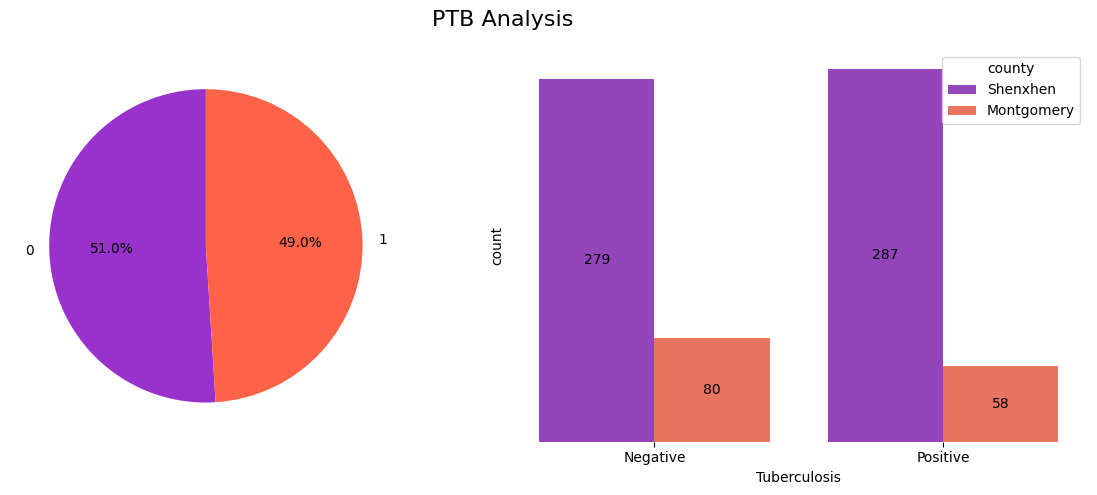

In [7]:
# PTB value counts and gender-county distribution
agg_data = metadata.ptb.value_counts()
ct = pd.crosstab(metadata['gender'], metadata['ptb'])

plt.figure(figsize=(12,5))

# Pie Chart: PTB distribution
plt.subplot(121)
plt.pie(agg_data, labels=agg_data.index, autopct='%1.1f%%', startangle=90, colors=['darkorchid', 'tomato'])

# Bar Chart: PTB count by county
plt.subplot(122)
bars = sns.countplot(metadata, x='ptb', hue='county', palette=['darkorchid', 'tomato'])
plt.bar_label(bars.containers[0], label_type='center')
plt.bar_label(bars.containers[1], label_type='center')
plt.yticks([])
plt.xticks([0, 1], labels=['Negative', 'Positive'])
plt.xlabel('Tuberculosis')
plt.box(False)

# Plot title
plt.suptitle('PTB Analysis', fontsize=16)
plt.tight_layout()
plt.show()


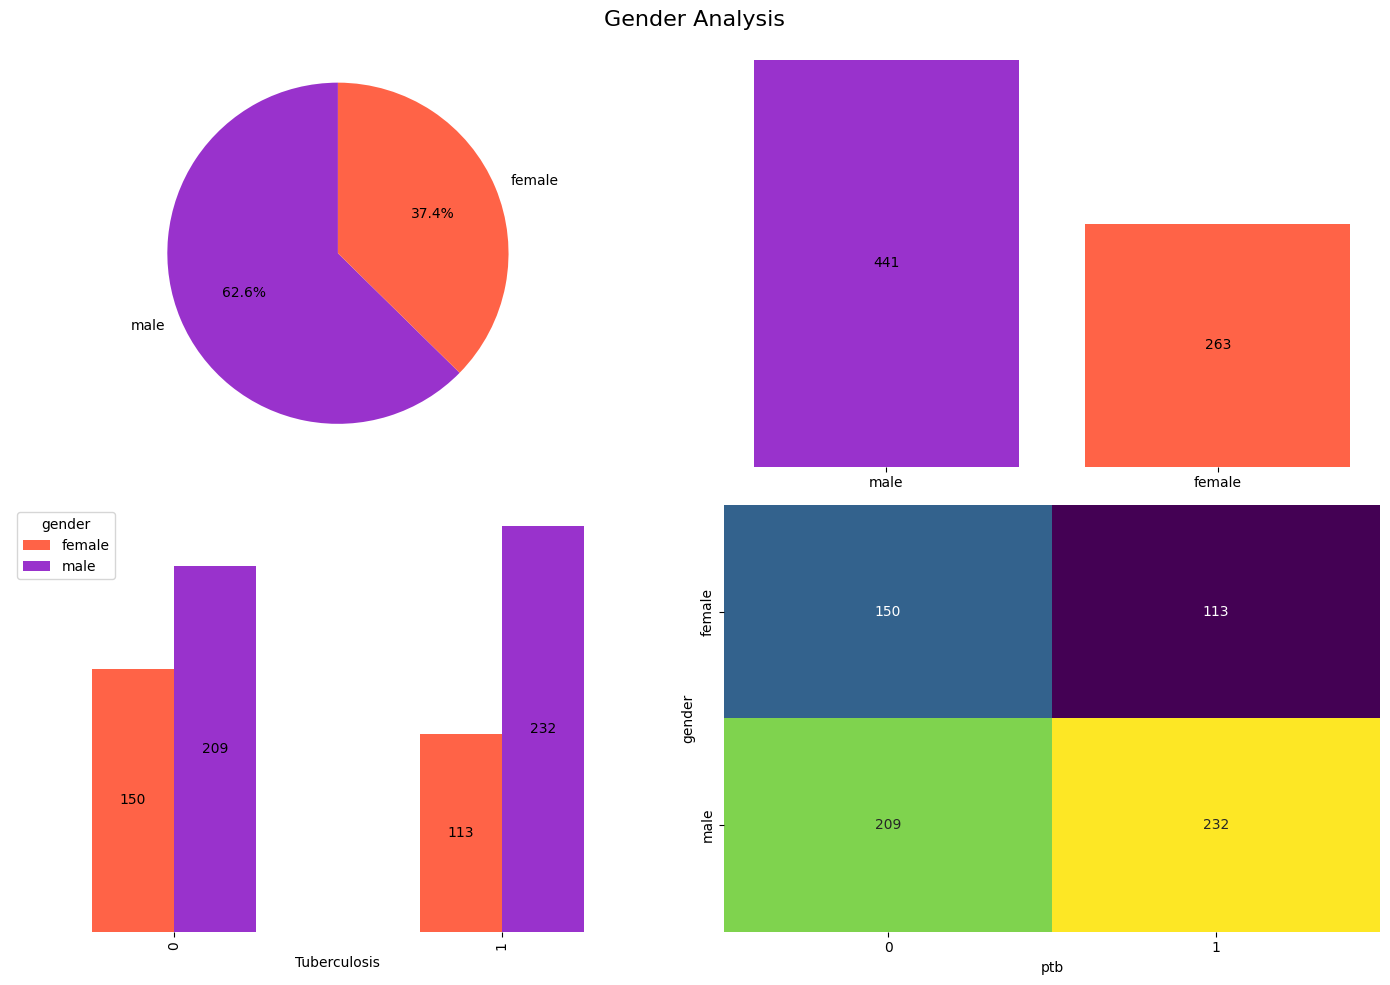

In [8]:
gender_mapping = {
    'm': 'male', 'Male,': 'male', 'male35yrs': 'male', 'male,':'male',
    'f': 'female', 'femal': 'female', 'female24yrs':'female','o':'female','female,':'female'
}
metadata.gender = metadata.gender.str.lower()
metadata.gender.replace(gender_mapping,inplace=True)
agg_data = metadata.gender.value_counts()
ct = pd.crosstab(metadata['gender'], metadata['ptb'])

plt.figure(figsize=(14,10))
plt.subplot(221)
plt.pie(agg_data,labels=agg_data.index,autopct='%1.1f%%', startangle=90,colors=['darkorchid','tomato'])

plt.subplot(222)
bars = plt.bar(agg_data.index,agg_data,color=['darkorchid','tomato'])
plt.bar_label(bars, labels=[str(height) for height in agg_data],label_type='center')
plt.yticks([])
plt.box(False)

plt.subplot(223)
bars = ct.T.plot(kind='bar', color=['tomato', 'darkorchid'],ax=plt.gca())
plt.bar_label(bars.containers[0], label_type='center')
plt.bar_label(bars.containers[1], label_type='center')
plt.xlabel('Tuberculosis')
plt.yticks([])
plt.box(False)

plt.subplot(224)
sns.heatmap(ct,annot=True,cbar=False,fmt='d',cmap='viridis')

plt.suptitle('Gender Analysis',fontsize=16)
plt.tight_layout()
plt.show()

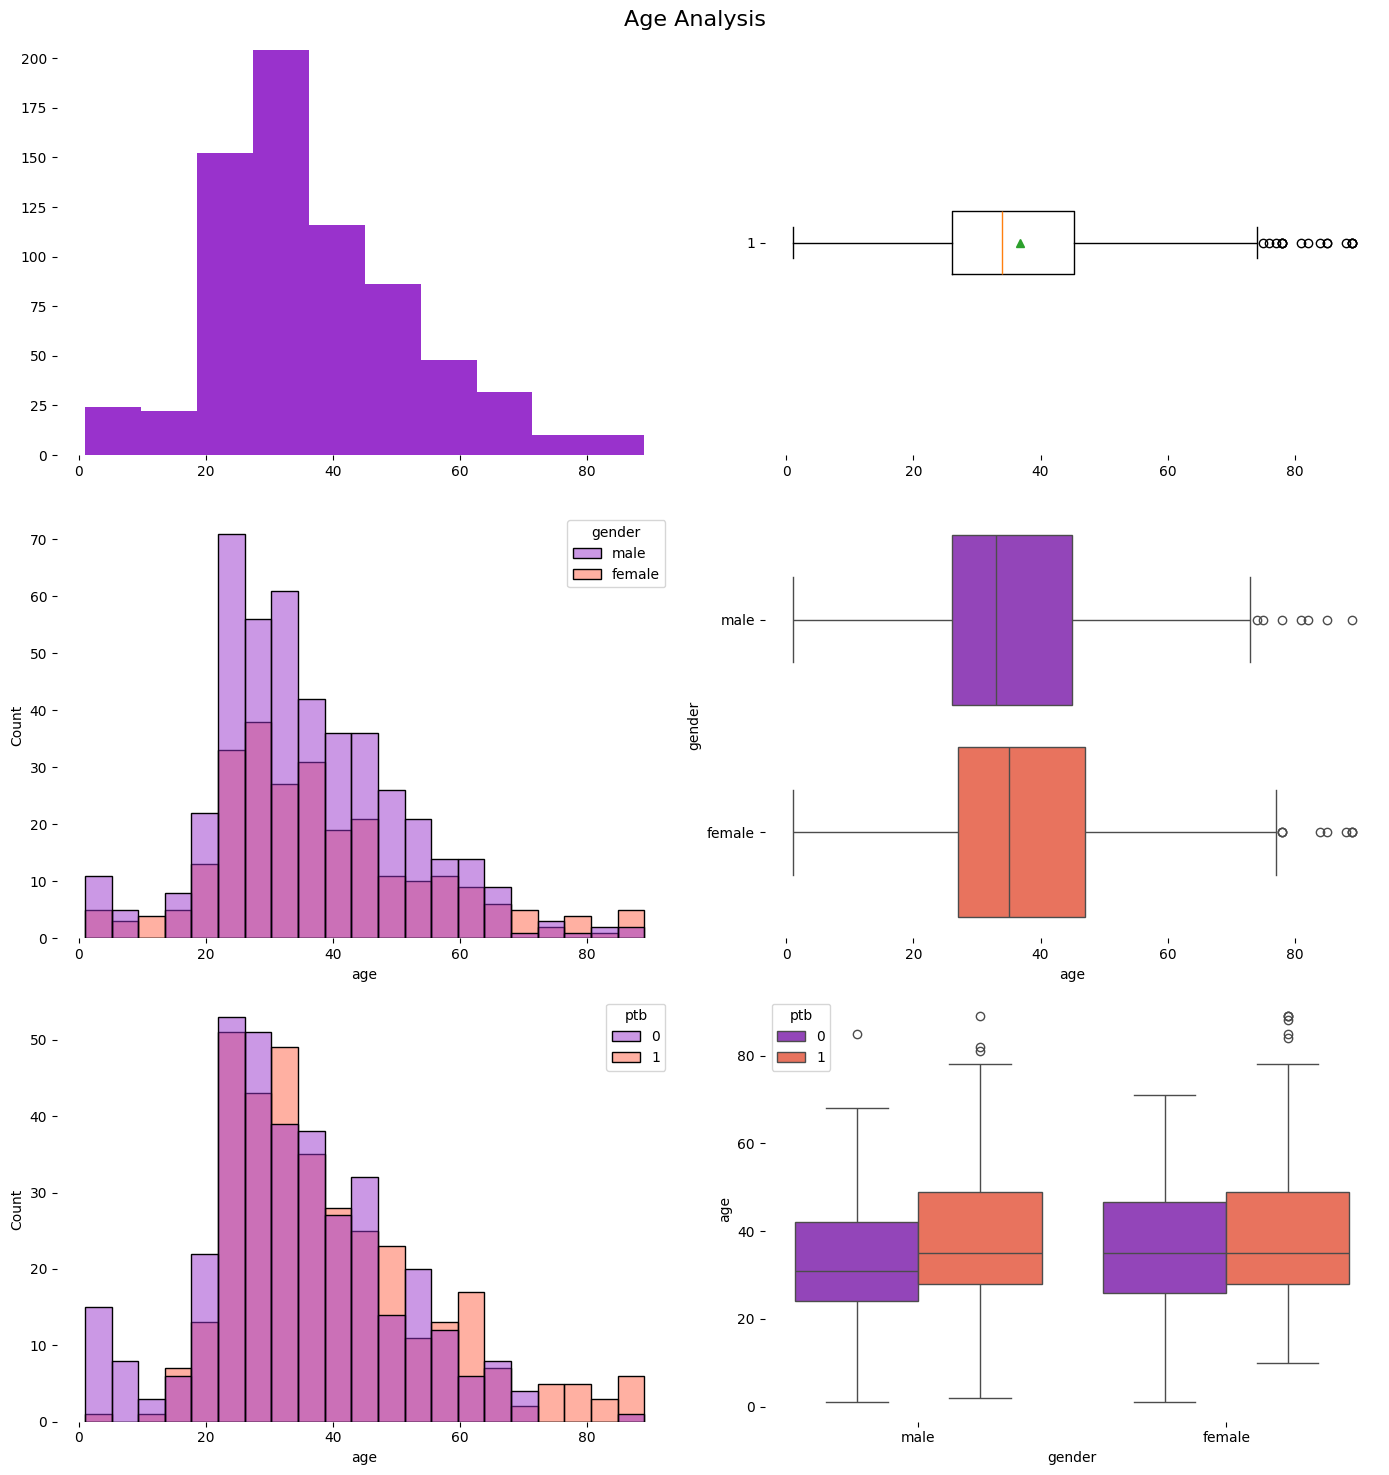

In [9]:
metadata.age = (metadata.age
                .replace({'16month':'1','39yr':'39','1yr':'1','male35':'35','female24':'24'})
                .astype(int))
custom_palette = ['darkorchid','tomato']

plt.figure(figsize=(14,15))
plt.subplot(321)
plt.hist(metadata.age,color='darkorchid')
plt.box(False)

plt.subplot(322)
plt.boxplot(metadata.age,vert=False,showmeans=True)
plt.box(False)

plt.subplot(323)
sns.histplot(metadata,x='age',hue='gender',palette=custom_palette)
plt.box(False)

plt.subplot(324)
sns.boxplot(metadata,x='age',y='gender',palette=custom_palette)
plt.box(False)

plt.subplot(325)
sns.histplot(metadata,x='age',hue='ptb',palette=custom_palette)
plt.box(False)

plt.subplot(326)
sns.boxplot(data=metadata, x='gender', y='age', hue='ptb', palette=custom_palette)
plt.box(False)


plt.suptitle('Age Analysis',fontsize=16)
plt.tight_layout()
plt.show()

<Figure size 1400x800 with 0 Axes>

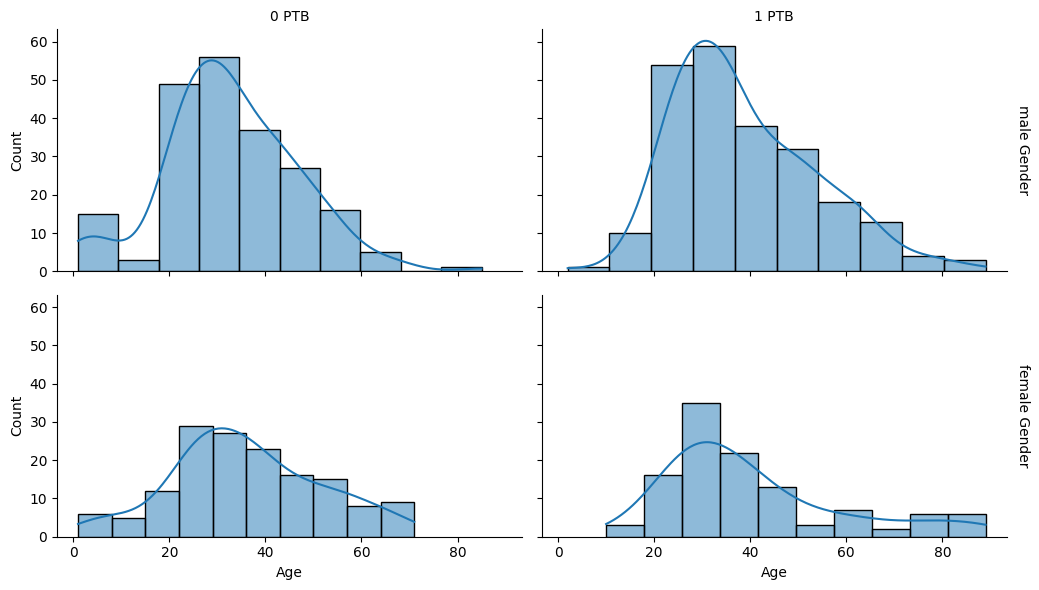

In [10]:
# FacetGrid of Age by Gender and PTB
plt.figure(figsize=(14,8))
g = sns.FacetGrid(metadata, col='ptb', row='gender', margin_titles=True,aspect=1.75)
g.map(sns.histplot, 'age', bins=10, kde=True)

# Adding titles and labels
g.set_axis_labels('Age', 'Count')
g.set_titles(col_template="{col_name} PTB", row_template="{row_name} Gender")

# Show the plot
plt.show()

In [ ]:
import os
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil
import uuid

BASE_DIR = "/content/Chest-X-Ray-Clean"

# 1️⃣ Clean previous extractions
shutil.rmtree(BASE_DIR, ignore_errors=True)
os.makedirs(BASE_DIR, exist_ok=True)

# 2️⃣ Unzip fresh
!unzip -o "/content/chest-x-ray-lungs-segmentation.zip" -d "{BASE_DIR}" > /dev/null

# 3️⃣ Create image & mask folders
IMG_DIR = os.path.join(BASE_DIR, "image")
MSK_DIR = os.path.join(BASE_DIR, "mask")
os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(MSK_DIR, exist_ok=True)

# 4️⃣ Move & rename files to avoid overwriting
for root, _, files in os.walk(BASE_DIR):
    for file in files:
        if file.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".bmp")):
            src = os.path.join(root, file)
            new_name = file
            if os.path.exists(os.path.join(BASE_DIR, new_name)):
                # Avoid overwriting
                name, ext = os.path.splitext(file)
                new_name = f"{name}_{uuid.uuid4().hex[:6]}{ext}"
            shutil.move(src, os.path.join(BASE_DIR, new_name))

# 5️⃣ Dynamically detect masks by analyzing images
for file in os.listdir(BASE_DIR):
    if file.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".bmp")):
        img = imread(os.path.join(BASE_DIR, file))
        # Masks are usually binary (very few unique pixel values)
        if len(np.unique(img)) <= 10:
            shutil.move(os.path.join(BASE_DIR, file), os.path.join(MSK_DIR, file))
        else:
            shutil.move(os.path.join(BASE_DIR, file), os.path.join(IMG_DIR, file))

print("✅ Images found:", len(os.listdir(IMG_DIR)))
print("✅ Masks found:", len(os.listdir(MSK_DIR)))

# 6️⃣ Generate heatmap
filenames = sorted(os.listdir(MSK_DIR))
if not filenames:
    raise ValueError("No mask files found even after dynamic detection.")

heatmap = np.zeros((1024, 1024))
for file in tqdm(filenames, total=len(filenames)):
    msk = imread(os.path.join(MSK_DIR, file), as_gray=True)
    msk = resize(msk, (1024, 1024), preserve_range=True)
    heatmap += msk

heatmap /= len(filenames)

plt.figure(figsize=(10, 10))
plt.imshow(heatmap, cmap='coolwarm')
plt.title("Mask Heatmap")
plt.axis('off')
plt.show()



In [11]:
def get_colored_mask(image, mask_image, color=[255, 20, 255]):
    mask_image_gray = cv2.cvtColor(mask_image, cv2.COLOR_BGR2GRAY)
    mask = cv2.bitwise_and(mask_image, mask_image, mask=mask_image_gray)
    mask_coord = np.where(mask != [0, 0, 0])
    mask[mask_coord[0], mask_coord[1], :] = color
    ret = cv2.addWeighted(image, 0.6, mask, 0.4, 0)
    return ret

# Ensure paths exist and contain files
IMG_PATH = '/content/chest_xray_lung_segmentation/chest_xray/train/CXR/'
MSK_PATH = '/content/chest_xray_lung_segmentation/chest_xray/train/Mask/'

# Safely get filenames
file_list = next(os.walk(IMG_PATH), (None, None, []))[2]
filenames = file_list[:3]

for file in filenames:
    img = imread(os.path.join(IMG_PATH, file))
    msk = imread(os.path.join(MSK_PATH, file))

    plt.figure(figsize=(15, 5))

    plt.subplot(131)
    plt.imshow(img)
    plt.yticks([])
    plt.xticks([])
    plt.box(False)
    plt.title("Original Image")

    plt.subplot(132)
    plt.imshow(msk, cmap='binary_r')
    plt.yticks([])
    plt.xticks([])
    plt.box(False)
    plt.title("Mask")

    plt.subplot(133)
    plt.imshow(get_colored_mask(img, msk))
    plt.yticks([])
    plt.xticks([])
    plt.box(False)
    plt.title("Overlay")

    plt.tight_layout()
    plt.show()

In [12]:
# 1️⃣ Extract dataset
!unzip -o "/content/chest-x-ray-lungs-segmentation.zip" -d "/content/Chest-X-Ray"

# 2️⃣ Move all PNG files from any subfolder (no matter how deep) to main folder
!find /content/Chest-X-Ray -type f -iname "*.png" -exec mv -t /content/Chest-X-Ray/ {} +

# 3️⃣ Remove all empty subfolders
!find /content/Chest-X-Ray -type d -empty -delete

# 4️⃣ Create image and mask folders
!mkdir -p /content/Chest-X-Ray/image /content/Chest-X-Ray/mask

# 5️⃣ Separate mask files from normal images
!find /content/Chest-X-Ray -maxdepth 1 -type f -iname "*.png" -exec bash -c '[[ "$1" == *mask* ]] && mv "$1" /content/Chest-X-Ray/mask/ || mv "$1" /content/Chest-X-Ray/image/' _ {} \;


Archive:  /content/chest-x-ray-lungs-segmentation.zip
  inflating: /content/Chest-X-Ray/Chest-X-Ray/Chest-X-Ray/image/1000.png  
  inflating: /content/Chest-X-Ray/Chest-X-Ray/Chest-X-Ray/image/1001.png  
  inflating: /content/Chest-X-Ray/Chest-X-Ray/Chest-X-Ray/image/1002.png  
  inflating: /content/Chest-X-Ray/Chest-X-Ray/Chest-X-Ray/image/1003.png  
  inflating: /content/Chest-X-Ray/Chest-X-Ray/Chest-X-Ray/image/1004.png  
  inflating: /content/Chest-X-Ray/Chest-X-Ray/Chest-X-Ray/image/1005.png  
  inflating: /content/Chest-X-Ray/Chest-X-Ray/Chest-X-Ray/image/1006.png  
  inflating: /content/Chest-X-Ray/Chest-X-Ray/Chest-X-Ray/image/1007.png  
  inflating: /content/Chest-X-Ray/Chest-X-Ray/Chest-X-Ray/image/1008.png  
  inflating: /content/Chest-X-Ray/Chest-X-Ray/Chest-X-Ray/image/1009.png  
  inflating: /content/Chest-X-Ray/Chest-X-Ray/Chest-X-Ray/image/1010.png  
  inflating: /content/Chest-X-Ray/Chest-X-Ray/Chest-X-Ray/image/1011.png  
  inflating: /content/Chest-X-Ray/Chest-X-Ray/

✅ Images found: 704
✅ Masks found: 704


100%|██████████| 704/704 [05:35<00:00,  2.10it/s]


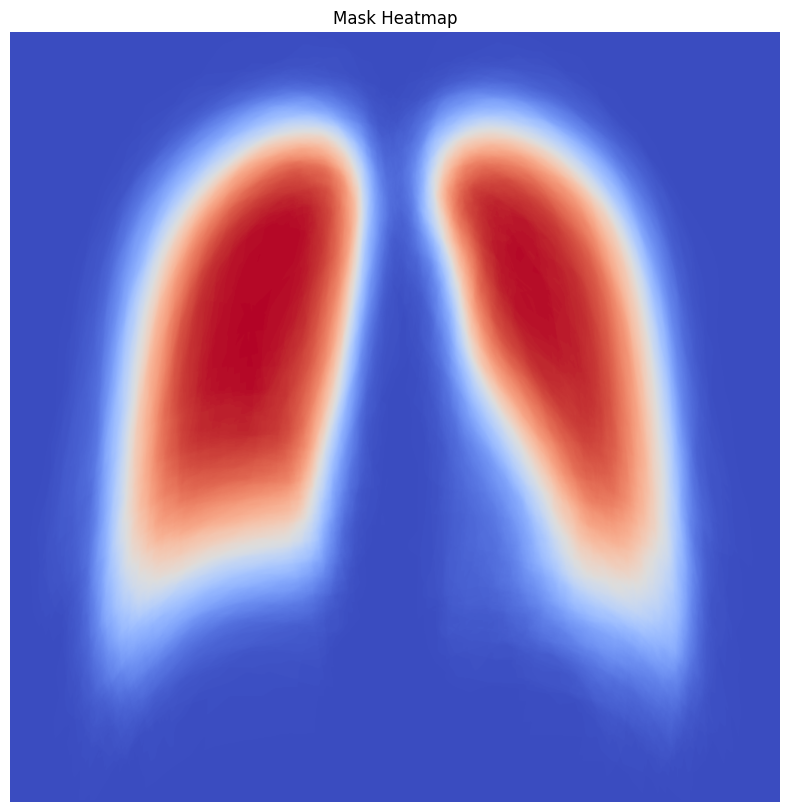

In [13]:
import os
import numpy as np
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
from tqdm import tqdm
import shutil
import zipfile

BASE_DIR = "/content/Chest-X-Ray-Clean"

# 1️⃣ Clean previous extractions
shutil.rmtree(BASE_DIR, ignore_errors=True)
os.makedirs(BASE_DIR, exist_ok=True)

# 2️⃣ Unzip fresh dataset
with zipfile.ZipFile("/content/chest-x-ray-lungs-segmentation.zip", 'r') as zip_ref:
    zip_ref.extractall(BASE_DIR)

# 3️⃣ Create image & mask folders
IMG_DIR = os.path.join(BASE_DIR, "image")
MSK_DIR = os.path.join(BASE_DIR, "mask")
os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(MSK_DIR, exist_ok=True)

# 4️⃣ Detect & move files (binary masks vs normal images)
for root, _, files in os.walk(BASE_DIR):
    for file in files:
        if file.lower().endswith((".png", ".jpg", ".jpeg", ".tif", ".bmp")):
            path = os.path.join(root, file)
            img = imread(path)
            if len(np.unique(img)) <= 10:
                shutil.move(path, os.path.join(MSK_DIR, file))
            else:
                shutil.move(path, os.path.join(IMG_DIR, file))

print("✅ Images found:", len(os.listdir(IMG_DIR)))
print("✅ Masks found:", len(os.listdir(MSK_DIR)))

# 5️⃣ Generate heatmap
filenames = sorted(os.listdir(MSK_DIR))
if not filenames:
    raise ValueError("No mask files found even after dynamic detection.")

heatmap = np.zeros((1024, 1024))
for file in tqdm(filenames, total=len(filenames)):
    msk = imread(os.path.join(MSK_DIR, file), as_gray=True)
    msk = resize(msk, (1024, 1024), preserve_range=True)
    heatmap += msk

heatmap /= len(filenames)

plt.figure(figsize=(10, 10))
plt.imshow(heatmap, cmap='coolwarm')
plt.title("Mask Heatmap")
plt.axis('off')
plt.show()


In [17]:
import os

BASE_PATH = "/content/Chest-X-Ray"

# ✅ Automatically find deepest folders containing images and masks
def find_folder(base_path, keyword):
    for root, dirs, files in os.walk(base_path):
        if any(keyword in d.lower() for d in dirs):
            return os.path.join(root, [d for d in dirs if keyword in d.lower()][0])
    return None

IMG_PATH = find_folder(BASE_PATH, "image")
MSK_PATH = find_folder(BASE_PATH, "mask")

print("✅ Auto-detected paths:")
print("Images:", IMG_PATH)
print("Masks:", MSK_PATH)


✅ Auto-detected paths:
Images: /content/Chest-X-Ray/image
Masks: /content/Chest-X-Ray/mask


In [19]:
import os

print("🔍 Checking MASK folder files...")
mask_files = sorted(os.listdir(MSK_PATH))
print("Total masks found:", len(mask_files))
print("Sample masks:", mask_files[:20])


🔍 Checking MASK folder files...
Total masks found: 0
Sample masks: []


In [20]:
import os
import shutil

# Remove old dataset
shutil.rmtree("/content/Chest-X-Ray", ignore_errors=True)

# Unzip dataset again
!unzip -q "/content/chest-x-ray-lungs-segmentation.zip" -d "/content/Chest-X-Ray-Raw"

# Move images and masks from any subfolder
!mkdir -p /content/Chest-X-Ray/image /content/Chest-X-Ray/mask

# Move mask files (all formats)
!find /content/Chest-X-Ray-Raw -type f \( -iname "*mask*.png" -o -iname "*mask*.jpg" -o -iname "*mask*.jpeg" -o -iname "*.tif" \) -exec mv -t /content/Chest-X-Ray/mask/ {} +

# Move image files (all formats except masks)
!find /content/Chest-X-Ray-Raw -type f \( -iname "*.png" -o -iname "*.jpg" -o -iname "*.jpeg" -o -iname "*.tif" \) ! -iname "*mask*" -exec mv -t /content/Chest-X-Ray/image/ {} +

print("✅ Images:", len(os.listdir("/content/Chest-X-Ray/image")))
print("✅ Masks:", len(os.listdir("/content/Chest-X-Ray/mask")))


mv: will not overwrite just-created '/content/Chest-X-Ray/image/1018.png' with '/content/Chest-X-Ray-Raw/Chest-X-Ray/Chest-X-Ray/mask/1018.png'
mv: will not overwrite just-created '/content/Chest-X-Ray/image/1199.png' with '/content/Chest-X-Ray-Raw/Chest-X-Ray/Chest-X-Ray/mask/1199.png'
mv: will not overwrite just-created '/content/Chest-X-Ray/image/1017.png' with '/content/Chest-X-Ray-Raw/Chest-X-Ray/Chest-X-Ray/mask/1017.png'
mv: will not overwrite just-created '/content/Chest-X-Ray/image/1596.png' with '/content/Chest-X-Ray-Raw/Chest-X-Ray/Chest-X-Ray/mask/1596.png'
mv: will not overwrite just-created '/content/Chest-X-Ray/image/1208.png' with '/content/Chest-X-Ray-Raw/Chest-X-Ray/Chest-X-Ray/mask/1208.png'
mv: will not overwrite just-created '/content/Chest-X-Ray/image/1277.png' with '/content/Chest-X-Ray-Raw/Chest-X-Ray/Chest-X-Ray/mask/1277.png'
mv: will not overwrite just-created '/content/Chest-X-Ray/image/1085.png' with '/content/Chest-X-Ray-Raw/Chest-X-Ray/Chest-X-Ray/mask/10

In [22]:
import os
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import keras

# ✅ Use the cleaned dataset paths from heatmap step
BASE_DIR = "/content/Chest-X-Ray-Clean"
IMG_PATH = os.path.join(BASE_DIR, "image")
MSK_PATH = os.path.join(BASE_DIR, "mask")

print("✅ Image Path:", IMG_PATH)
print("✅ Mask Path:", MSK_PATH)

# ✅ Normalize filenames (ignore case, remove prefixes)
def normalize_name(filename):
    return filename.lower().replace("mask_", "").replace("image_", "").replace(".png", "").replace(".jpg", "")

# ✅ List all files
img_files_raw = sorted(os.listdir(IMG_PATH))
msk_files_raw = sorted(os.listdir(MSK_PATH))

# ✅ Create maps
img_map = {normalize_name(f): f for f in img_files_raw}
msk_map = {normalize_name(f): f for f in msk_files_raw}

# ✅ Find matched files
common_keys = sorted(set(img_map.keys()) & set(msk_map.keys()))
img_files = [img_map[k] for k in common_keys]
msk_files = [msk_map[k] for k in common_keys]

print(f"✅ Matched pairs: {len(common_keys)}")
print("🔴 Images without masks:", list(set(img_map.keys()) - set(msk_map.keys()))[:5])
print("🔴 Masks without images:", list(set(msk_map.keys()) - set(img_map.keys()))[:5])

# ✅ DataGenerator
class DataGenerator(keras.utils.Sequence):
    def __init__(self, img_files, mask_files, img_path, mask_path,
                 batch_size=4, size=(256, 256), shuffle=True, augment=False):
        self.img_filenames = img_files
        self.mask_filenames = mask_files
        self.img_path = img_path
        self.mask_path = mask_path
        self.batch_size = batch_size
        self.size = size
        self.shuffle = shuffle
        self.augment = augment
        self.indexes = np.arange(len(self.img_filenames))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.img_filenames) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        images, masks = [], []

        for idx in batch_indices:
            img = imread(os.path.join(self.img_path, self.img_filenames[idx]), as_gray=True)
            img = resize(img, self.size, preserve_range=True, anti_aliasing=True)
            img = np.expand_dims(img.astype(np.float32) / 255.0, axis=-1)

            mask = imread(os.path.join(self.mask_path, self.mask_filenames[idx]), as_gray=True)
            mask = resize(mask, self.size, preserve_range=True, anti_aliasing=False)
            mask = np.expand_dims((mask.astype(np.float32) / 255.0) > 0.5, axis=-1)

            if self.augment:
                if np.random.rand() > 0.5:
                    img = np.fliplr(img)
                    mask = np.fliplr(mask)
                if np.random.rand() > 0.5:
                    img = np.flipud(img)
                    mask = np.flipud(mask)

            images.append(img)
            masks.append(mask.astype(np.float32))

        return np.array(images), np.array(masks)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# ✅ Train/validation split
if len(img_files) > 1:
    train_img_files, val_img_files, train_msk_files, val_msk_files = train_test_split(
        img_files, msk_files, test_size=0.3, random_state=1
    )
else:
    raise ValueError("Dataset too small or filenames mismatched.")

# ✅ Create data generators
train_data = DataGenerator(train_img_files, train_msk_files, IMG_PATH, MSK_PATH,
                           batch_size=4, size=(256, 256), shuffle=True, augment=True)
val_data = DataGenerator(val_img_files, val_msk_files, IMG_PATH, MSK_PATH,
                         batch_size=4, size=(256, 256), shuffle=False)

print("✅ Data Generators Ready!")



✅ Image Path: /content/Chest-X-Ray-Clean/image
✅ Mask Path: /content/Chest-X-Ray-Clean/mask
✅ Matched pairs: 704
🔴 Images without masks: []
🔴 Masks without images: []
✅ Data Generators Ready!


In [23]:
from tensorflow.keras import layers, models

def unet_optimized(input_shape=(256, 256, 1), num_classes=1, dropout_rate=0.2):
    """
    Optimized U-Net architecture for faster training on Colab GPU.
    - Reduced input size (256x256)
    - Added Dropout for regularization
    - BatchNormalization after every conv layer
    - Uses LeakyReLU (faster convergence than ReLU)
    """

    def conv_block(x, filters):
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(0.1)(x)
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(0.1)(x)
        x = layers.Dropout(dropout_rate)(x)
        return x

    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = conv_block(inputs, 32)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 64)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 128)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 256)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = conv_block(p4, 512)

    # Decoder
    u6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = conv_block(u6, 256)

    u7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = conv_block(u7, 128)

    u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = conv_block(u8, 64)

    u9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = conv_block(u9, 32)

    # Output
    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs, outputs)
    return model


# ✅ Instantiate the optimized model
input_shape = (256, 256, 1)  # Reduced size for faster training
model = unet_optimized(input_shape=input_shape, num_classes=1)

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        320 │ cast[0][0]        │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ leaky_re_lu[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256, 256,  │          0 │ leaky_re_lu_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ dropout[0][0]     │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ leaky_re_lu_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 128,  │          0 │ leaky_re_lu_3[0]

 Total params: 7,771,297 (29.65 MB)

 Trainable params: 7,765,409 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [24]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# ------------------ Metrics ------------------
# Jaccard Index (IoU)
def jaccard_index(y_true, y_pred, smooth=1e-6):
    """Calculates Intersection over Union (IoU) with smoothing to avoid division by zero."""
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    total = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (total + smooth)

# Dice Coefficient
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """Calculates Dice Score for segmentation tasks."""
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


# ------------------ Compile Model ------------------
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', dice_coefficient, jaccard_index]
)

print("✅ Model compiled successfully.")

# ------------------ Save Model Path ------------------
drive_model_path = "/content/drive/MyDrive/best_model.keras"

# ------------------ Checkpoint Callback ------------------
checkpoint = ModelCheckpoint(
    drive_model_path,
    monitor='val_dice_coefficient',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False
)

print("✅ Model checkpoint configured. Best model will be saved to Google Drive during training.")


✅ Model compiled successfully.
✅ Model checkpoint configured. Best model will be saved to Google Drive during training.


In [25]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import mixed_precision

# ✅ Enable mixed precision for faster training on Colab GPU
mixed_precision.set_global_policy('mixed_float16')

# ✅ Save model to Google Drive
drive_model_path = "/content/drive/MyDrive/best_model.keras"

# ✅ ModelCheckpoint: Save model with best Dice score
checkpoint = ModelCheckpoint(
    filepath=drive_model_path,
    monitor='val_dice_coefficient',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False
)

# ✅ EarlyStopping: Stop training when Dice score stops improving
early_stop = EarlyStopping(
    monitor='val_dice_coefficient',
    patience=6,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

# ✅ Train or Resume Model
print("🚀 Starting/Resuming Training...")

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=36,
    callbacks=[checkpoint, early_stop]
)

print("✅ Training complete. Best model saved at:", drive_model_path)


🚀 Starting/Resuming Training...
Epoch 1/36
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8208 - dice_coefficient: 0.5302 - jaccard_index: 0.3780 - loss: 0.3885
Epoch 1: val_dice_coefficient improved from -inf to 0.54998, saving model to /content/drive/MyDrive/best_model.keras
123/123 ━━━━━━━━━━━━━━━━━━━━ 857s 6s/step - accuracy: 0.8211 - dice_coefficient: 0.5309 - jaccard_index: 0.3787 - loss: 0.3879 - val_accuracy: 0.5955 - val_dice_coefficient: 0.5500 - val_jaccard_index: 0.3815 - val_loss: 3.8687
Epoch 2/36
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9044 - dice_coefficient: 0.7213 - jaccard_index: 0.5690 - loss: 0.2349
Epoch 2: val_dice_coefficient did not improve from 0.54998
123/123 ━━━━━━━━━━━━━━━━━━━━ 754s 6s/step - accuracy: 0.9044 - dice_coefficient: 0.7214 - jaccard_index: 0.5691 - loss: 0.2348 - val_accuracy: 0.3092 - val_dice_coefficient: 0.4185 - val_jaccard_index: 0.2659 - val_loss: 8.1666
Epoch 3/36
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0

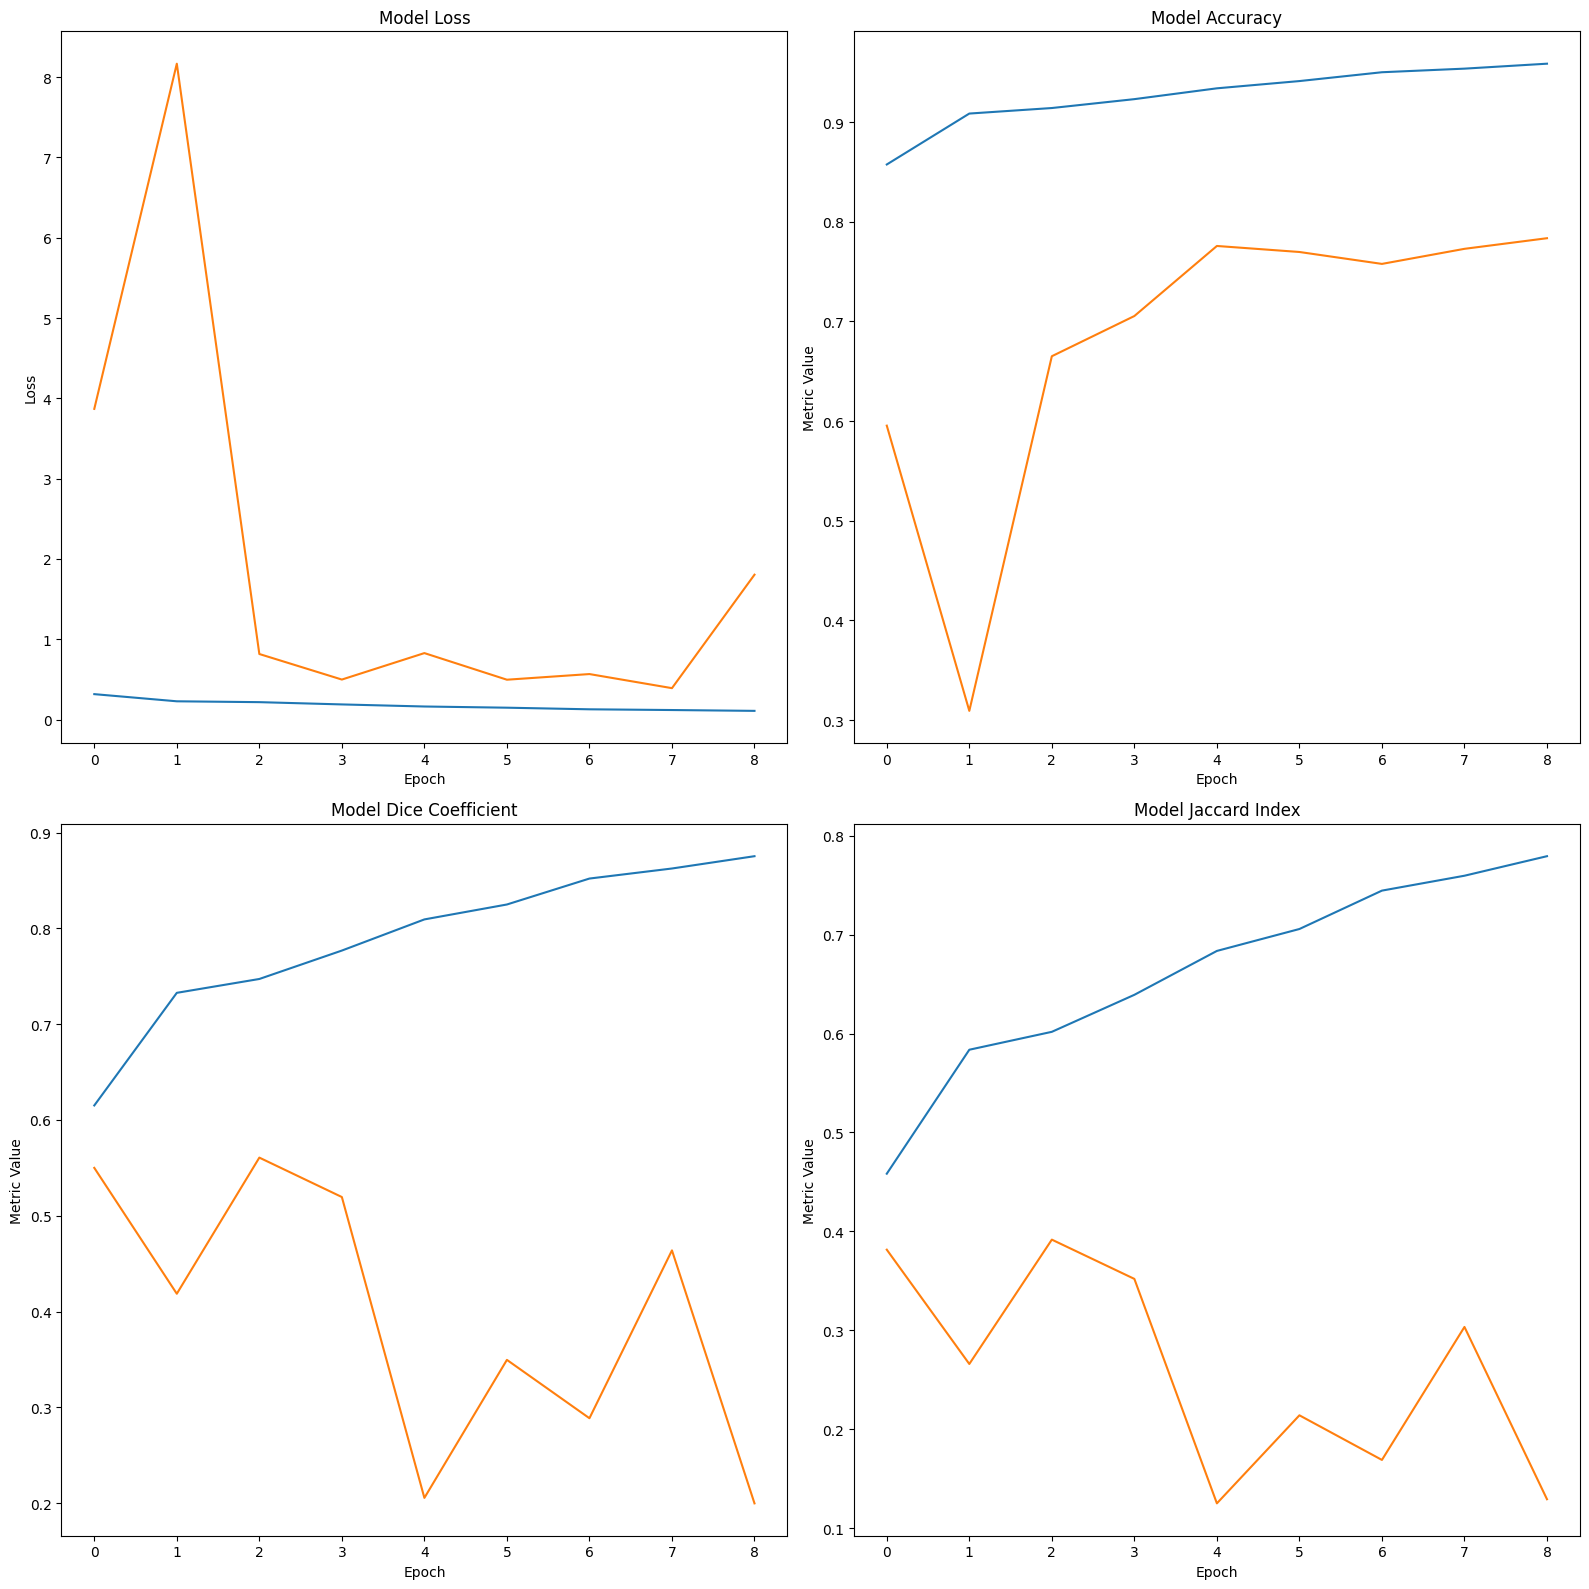

In [26]:
# Plot training & validation loss values
plt.figure(figsize=(16,16))
plt.subplot(221)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.subplot(222)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')

plt.subplot(223)
plt.plot(history.history['dice_coefficient'], label='Train Dice Coefficient')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.title('Model Dice Coefficient')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')

plt.subplot(224)
plt.plot(history.history['jaccard_index'], label='Train Jaccard Index')
plt.plot(history.history['val_jaccard_index'], label='Validation Jaccard Index')
plt.title('Model Jaccard Index')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

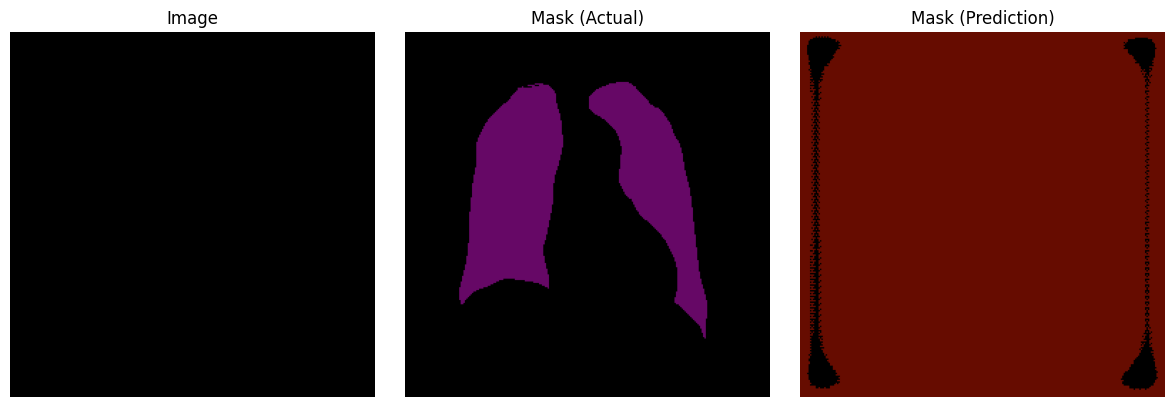

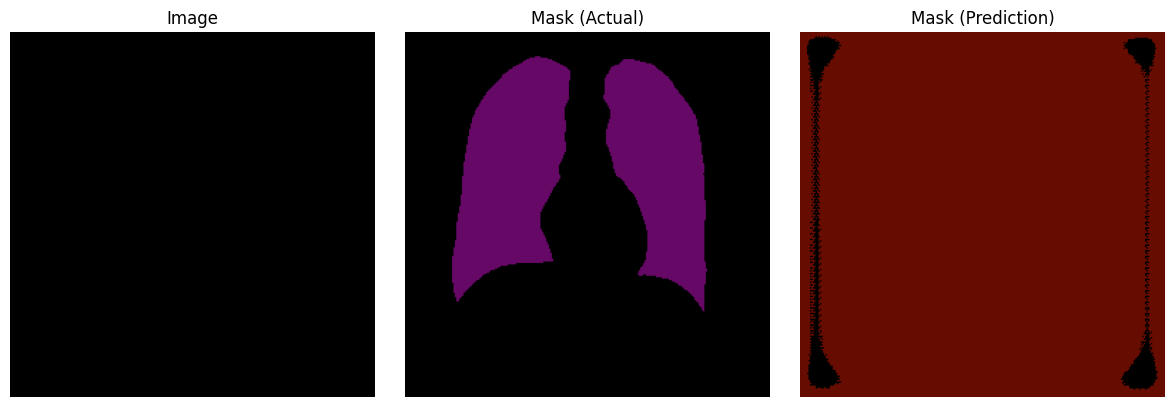

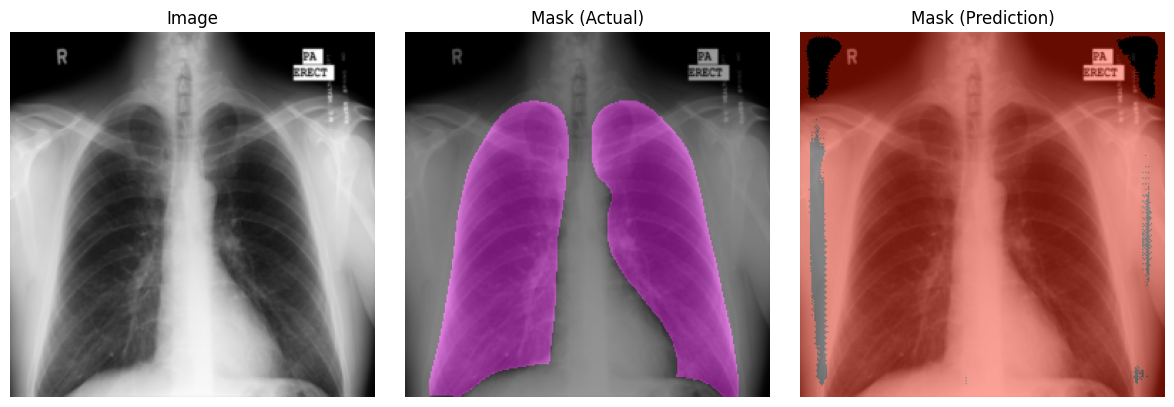

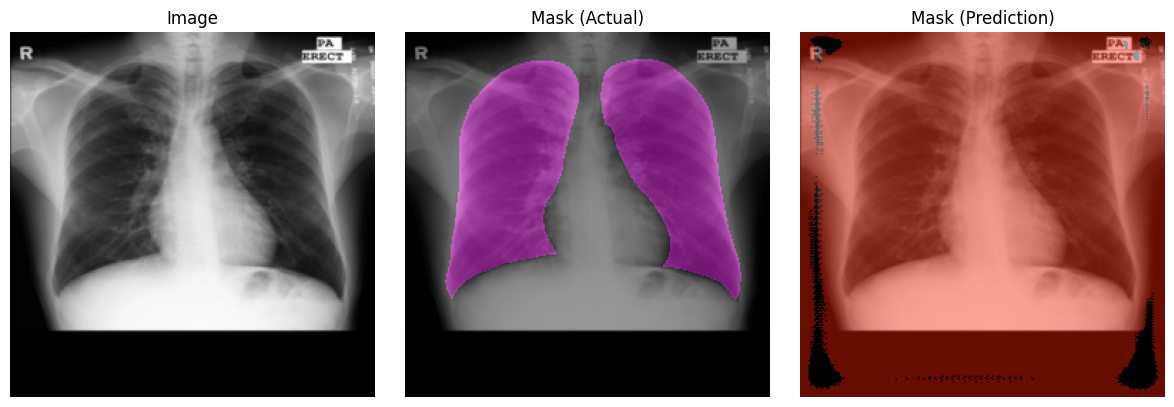

In [29]:
imgs, msks  = val_data.__getitem__(1)

for img,msk in zip(imgs,msks):
    img = np.expand_dims(img, axis=0)
    pred = (np.squeeze(model.predict(img,verbose=0))*255).astype(np.uint8)
    img = (np.squeeze(img) * 255).astype(np.uint8)
    msk = (msk*255).astype(np.uint8)

    # Convert grayscale image to RGB
    img= cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    msk = cv2.cvtColor(msk, cv2.COLOR_GRAY2RGB)
    pred = cv2.cvtColor(pred, cv2.COLOR_GRAY2RGB)

    plt.figure(figsize=(12,4))

    plt.subplot(131)
    plt.imshow(img)
    plt.title('Image')
    plt.yticks([])
    plt.xticks([])
    plt.box(False)

    plt.subplot(132)
    plt.imshow(get_colored_mask(img,msk))
    plt.title('Mask (Actual)')
    plt.yticks([])
    plt.xticks([])
    plt.box(False)

    plt.subplot(133)
    plt.imshow(get_colored_mask(img,pred,color = [255,30,0]))
    plt.title('Mask (Prediction)')
    plt.yticks([])
    plt.xticks([])
    plt.box(False)

    plt.tight_layout()
    plt.show()